<a href="https://colab.research.google.com/github/Arcus0800/repo1/blob/main/NumIdentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
#hyperparameters
batch_size = 128
learning_rate = 0.001

input_size = 28*28
num_classes = 10
epoch = 5

In [67]:
dataset = MNIST(root='data/', train = True, download=True, transform=transforms.ToTensor())
train_ds, val_ds = torch.utils.data.random_split(dataset, [50000, 10000])   #data set of 60k is divided randomly between training ds and validation ds
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())    #separate dataset thats not meant for training

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(train_ds, batch_size*2)

4


torch.Size([1, 28, 28])

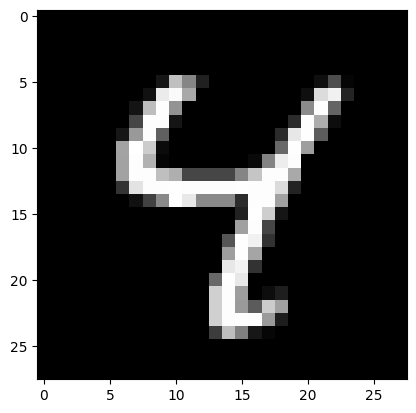

In [68]:
image, label = test_ds[6]
plt.imshow(image[0], cmap='gray')
print(label)
image.shape

In [69]:
class imgmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    x = x.reshape(-1, 28*28)
    x = self.linear(x)
    return x

  def training_step(self, batch):
    image, label = batch
    pred = self(image)
    loss = F.cross_entropy(pred, label)
    return loss

  def validation_step(self, batch):
    image, label = batch
    pred = self(image)
    loss = F.cross_entropy(pred, label)
    acc = accuracy(pred, label)
    return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = imgmodel()

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [70]:
def train(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:
      optimizer.zero_grad()
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
    res = evaluate(model, val_loader)
    model.epoch_end(epoch, res)
    history.append(res)
  return history



In [71]:
history = train(epoch, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9785, val_acc: 0.6009
Epoch [1], val_loss: 1.7066, val_acc: 0.7185
Epoch [2], val_loss: 1.5028, val_acc: 0.7544
Epoch [3], val_loss: 1.3486, val_acc: 0.7775
Epoch [4], val_loss: 1.2299, val_acc: 0.7916


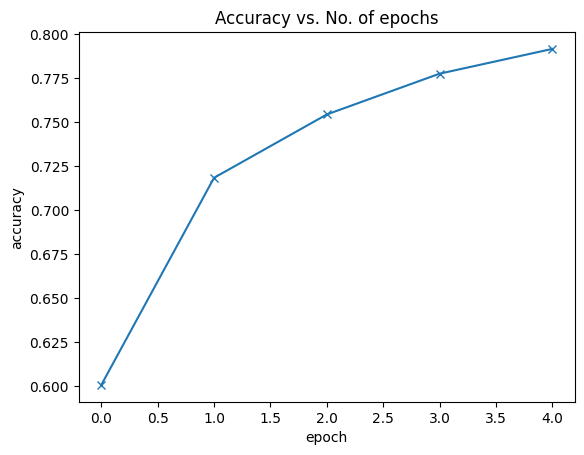

In [72]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [73]:
result = evaluate(model, test_loader)
result

{'val_loss': 1.216589331626892, 'val_acc': 0.7964006662368774}

In [74]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


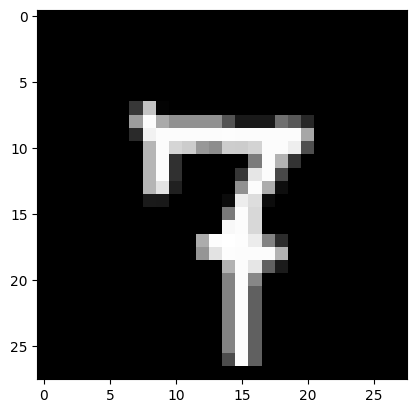

In [76]:
img, label = test_ds[987]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))